In [168]:
#for more advanced mapfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_mapnc_ugrid.py

import json
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt
import pandas as pd
from plot_functions import plot_xy_heatmap

### Post processing for map outputs Delft3D FLOW
This notebook displays :
- the grid of the model
- the bed level of the model
- the external forcings at a given time (wind/air temperature/cloud coverage)
- the water level at a given time
- the water velocity at a given time and depth
- the water temperature at a given time and depth
- the water temperature on a transect at a given time

It uses the **dfm_tools** package developed by Deltares (https://github.com/Deltares/dfm_tools)

**Interesting variables :**
mesh2d_flowelem_bl = bed level
mesh2d_s1 = water level
mesh2d_ucx = Flow element center velocity vector, x-component




# Set config variables

In [169]:
#set paths and parameters per model
#the necessary data is automatically downloaded from opendap if needed
model = 'lugano_1month_Flow'
time_plot = 191

In [170]:
with open('config_plots.json', 'r') as file:
    config_plots = json.load(file)[model]
    
file_nc_map = config_plots['file_nc_map']
sel_slice_x = slice(config_plots['sel_slice_x'][0],config_plots['sel_slice_x'][1])
sel_slice_y = slice(config_plots['sel_slice_y'][0],config_plots['sel_slice_y'][1])
crs = config_plots['crs']
raster_res = config_plots['raster_res']
umag_clim = config_plots['umag_clim']
scale = config_plots['scale']
line_array = np.array(config_plots['line_array'])

# Get data

In [171]:
#open+merge mapfile with xugrid(xarray) and print netcdf structure
uds_map = dfmt.open_dataset_delft3d4(file_nc_map)
time_plot_str = pd.to_datetime(uds_map["time"].values[time_plot]).strftime('%Y-%m-%d %H:%M')

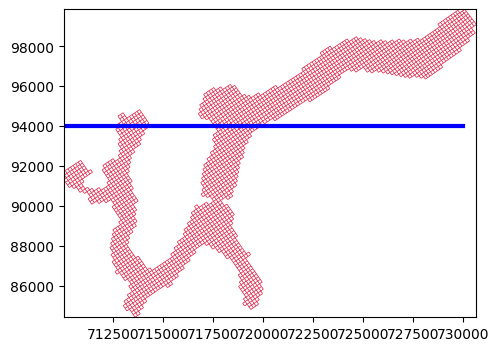

In [172]:
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map.grid.plot(edgecolor='crimson', linewidth=0.5)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)

In [173]:
x_flat = uds_map['XCOR'].values.flatten()
y_flat = uds_map['YCOR'].values.flatten()
mask = x_flat > 0
x_filt = x_flat[mask]
y_filt = y_flat[mask]

KeyError: "No variable named 'XCOR'. Variables on the dataset include ['XZ', 'YZ', 'ALFAS', 'KCS', 'DPS0', ..., 'ux', 'uy', 'umag', 'udir', 'mesh2d_nFaces']"

# Plot grid and bed level

In [ ]:
bed_level_flat = uds_map['DP0'].values.flatten()

bl_mask = bed_level_flat > 0
x_filt = x_flat[bl_mask]
y_filt = y_flat[bl_mask]
bed_level_filt = bed_level_flat[bl_mask]

#plot net/grid. use random variable and plot line to get grid
fig, ax = plt.subplots(figsize=(15,10))
pc = plt.scatter(x_filt, y_filt, c = bed_level_filt, s=10)
plt.colorbar()
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)


# Plot external forcing

In [ ]:
#plot external forcing on map, including windx/windy/air temperature
var1 = 'WINDU'
var2 = 'WINDV'
var3 = 'AIRTEM'
var4 = 'CLOUDS'

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10),sharex=True,sharey=True)
plt.suptitle(rf'time = {time_plot_str}')
pc1 = ax1.scatter(x_flat[bl_mask], y_flat[bl_mask], c = uds_map.isel(time=time_plot)[var1].values.flatten()[bl_mask], s=10, cmap='jet')
pc2 = ax2.scatter(x_flat[bl_mask], y_flat[bl_mask], c = uds_map.isel(time=time_plot)[var2].values.flatten()[bl_mask], s=10, cmap='jet')
pc3 = ax3.scatter(x_flat[bl_mask], y_flat[bl_mask], c = uds_map.isel(time=time_plot)[var3].values.flatten()[bl_mask], s=10, cmap='jet')
pc4 = ax4.scatter(x_flat[bl_mask], y_flat[bl_mask], c = uds_map.isel(time=time_plot)[var4].values.flatten()[bl_mask], s=10, cmap='jet')
cbar1 = plt.colorbar(pc1, ax=ax1)
cbar2 = plt.colorbar(pc2, ax=ax2)
cbar3 = plt.colorbar(pc3, ax=ax3)
cbar4 = plt.colorbar(pc4, ax=ax4)
ax1.set_title(var1)
ax2.set_title(var2)
ax3.set_title(var3)
ax4.set_title(var4)

for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)

In [ ]:
var = 'QEVA'
fig, ax = plt.subplots(figsize=(15,10))
plt.suptitle(rf'time = {time_plot_str}')
pc = ax.scatter(x_flat[bl_mask], y_flat[bl_mask], c = uds_map.isel(time=time_plot)[var].values.flatten()[bl_mask], s=20, cmap='jet') # , vmin = -1.6, vmax = 1.6
cbar = plt.colorbar(pc, ax=ax)
ax.set_title(var)

# Plot water level

In [ ]:
#plot water level on map
var = 'S1'
fig, ax = plt.subplots(figsize=(15,7))
pc =ax.scatter(x_flat[mask], y_flat[mask], c=uds_map[var].isel(time=time_plot).values.flatten()[mask], cmap='jet', s=5)
cbar = plt.colorbar(pc, ax=ax)
ax.set_title(var)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot velocity

In [ ]:
#plot eastward velocities on map, on depth from waterlevel/z0/bedlevel
depth_plot = -10
var='WPHY'
values_to_plot = uds_map[var].isel(time=time_plot).values[depth_plot].flatten()
temp_mask = values_to_plot > -999
fig, ax = plt.subplots(figsize=(15,7))
pc =ax.scatter(x_flat[temp_mask], y_flat[temp_mask], c=values_to_plot[temp_mask], cmap='jet', s=15)
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label(var)
ax.set_title(rf'time = {time_plot_str}, depth = {depth_plot} m')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot temperature

In [ ]:
#plot temperature on map, on depth from waterlevel/z0/bedlevel
depth_plot = -0
index_depth = (np.abs(uds_map['ZK_LYR'].values - depth_plot)).argmin()
var='R1'
values_to_plot = uds_map[var].isel(time=time_plot).values[0][index_depth].flatten()
temp_mask = values_to_plot > -999
fig, ax = plt.subplots(figsize=(15,7))
pc =ax.scatter(x_flat[temp_mask], y_flat[temp_mask], c=values_to_plot[temp_mask], cmap='jet', s=15)
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label(var)
ax.set_title(rf'time = {time_plot_str}, depth = {str(round(uds_map["ZK_LYR"].values[index_depth],1))} m')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Reference code
Can be useful but isn't used for the basic plots